# Analysis Notebook for Probing Experiments

This notebook loads the saved activation and probe result data, re‑runs PCA on the activations, and displays multi‑panel plots of the probing accuracies (using bar plots) along with a summary table of the results. You can change the dataset and experiment folder below if needed.

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# dataset = "controlled_sentences"
dataset = "wikitext_sentences"
model_name = "pythia1.4b"

experiment_folders = {
    "binary_inflection_dense": os.path.join("../output", "probes", f"{dataset}_{model_name}_binary_inflection_dense"),
    "binary_inflection_sparse": os.path.join("../output", "probes", f"{dataset}_{model_name}_binary_inflection_sparse"),
    "lexeme_dense": os.path.join("../output", "probes", f"{dataset}_{model_name}_lexeme_dense"),
    "lexeme_sparse": os.path.join("../output", "probes", f"{dataset}_{model_name}_lexeme_sparse"),
    "multiclass_inflection_dense": os.path.join("../output", "probes", f"{dataset}_{model_name}_multiclass_inflection_dense"),
    "multiclass_inflection_sparse": os.path.join("../output", "probes", f"{dataset}_{model_name}_multiclass_inflection_sparse")
}

print("Experiment Folders:")
for key, folder in experiment_folders.items():
    print(f"{key}: {folder}")

# Set paths for the activations and labels files.
activations_file = os.path.join("../output", f"{model_name}_{dataset}_reps.npz")
labels_file = os.path.join("../data", f"{dataset}.csv")

print("\nActivations File:", activations_file)
print("Labels File:", labels_file)

Experiment Folders:
binary_inflection_dense: ../output/probes/wikitext_sentences_pythia1.4b_binary_inflection_dense
binary_inflection_sparse: ../output/probes/wikitext_sentences_pythia1.4b_binary_inflection_sparse
lexeme_dense: ../output/probes/wikitext_sentences_pythia1.4b_lexeme_dense
lexeme_sparse: ../output/probes/wikitext_sentences_pythia1.4b_lexeme_sparse
multiclass_inflection_dense: ../output/probes/wikitext_sentences_pythia1.4b_multiclass_inflection_dense
multiclass_inflection_sparse: ../output/probes/wikitext_sentences_pythia1.4b_multiclass_inflection_sparse

Activations File: ../output/pythia1.4b_wikitext_sentences_reps.npz
Labels File: ../data/wikitext_sentences.csv


In [4]:
print("Loading activations and labels...")

# Load activations (assumed shape: (n_examples, n_layers, d_model))
data = np.load(activations_file)["activations"]
print("Activations shape:", data.shape)

# Load label CSV
df = pd.read_csv(labels_file)
inflection_labels_raw = df["Inflection Label"].values  # strings like "past", "present", etc.
lexeme_labels_raw = df["Lemma"].values

# Get unique lists for later mapping
unique_inflections = sorted(set(inflection_labels_raw))
unique_lexemes = sorted(set(lexeme_labels_raw))

print("Unique Inflection Labels:", unique_inflections)
print("Unique Lexemes (sample):", unique_lexemes[:10])

Loading activations and labels...
Activations shape: (25918, 25, 2048)
Unique Inflection Labels: ['base', 'past', 'plural', 'positive', 'singular']
Unique Lexemes (sample): ['FALSE', 'Greek', 'TRUE', 'abbey', 'able', 'absent', 'absolute', 'academic', 'academy', 'access']


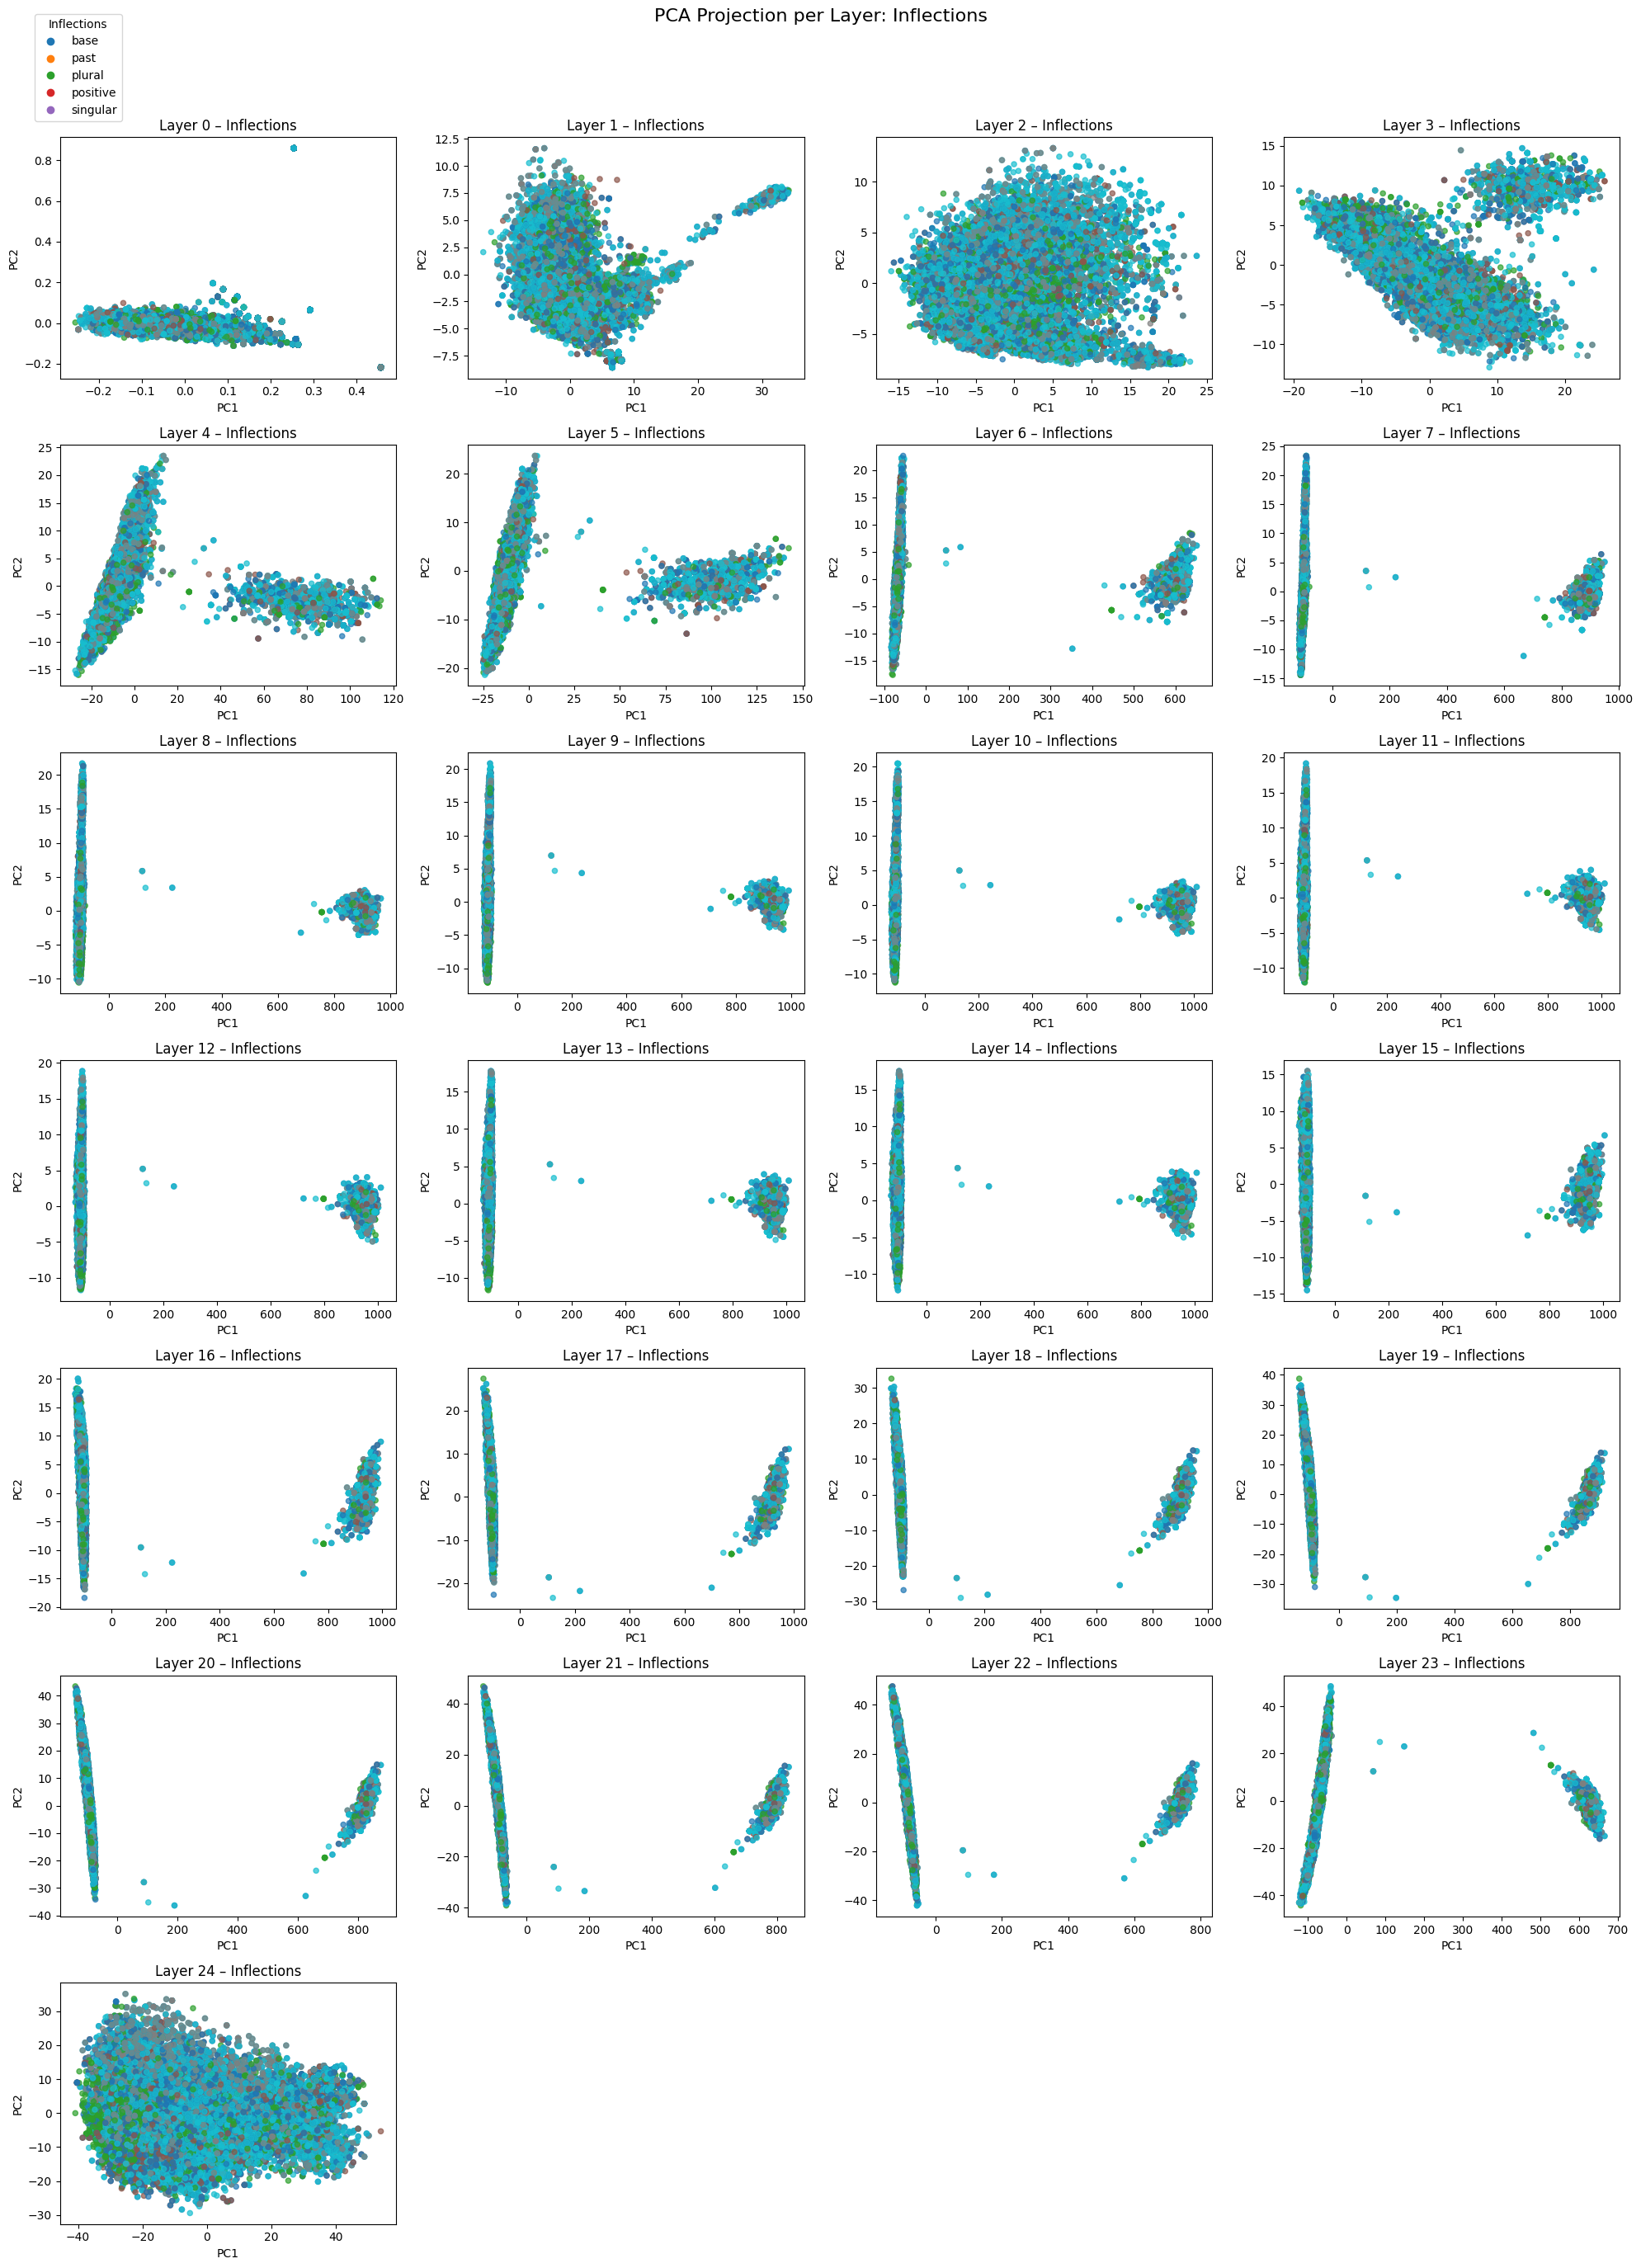

Saved PCA plot to output/analysis/pythia1.4b_wikitext_sentences_pca.png


In [5]:
from sklearn.decomposition import PCA
from matplotlib.lines import Line2D
from math import ceil

num_layers = data.shape[1]
cols = 4  # Number of columns in the subplot grid
rows = ceil(num_layers / cols)  # Calculate the number of rows needed

fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
axes = axes.flatten()

# Create mappings for discrete colors:
# For inflections, we'll use the 'tab10' palette.
inf_label_to_int = {label: i for i, label in enumerate(unique_inflections)}
inf_colors = {label: plt.get_cmap("tab10")(i % 10) for i, label in enumerate(unique_inflections)}

# Prepare numeric label arrays:
inflection_nums = np.array([inf_label_to_int[label] for label in inflection_labels_raw])

# Prepare handles for a common legend (one per column)
inf_handles = [Line2D([], [], marker='o', linestyle='None', markersize=6, 
                      color=inf_colors[label], label=label) for label in unique_inflections]

# Plot a row for each layer:
for layer in range(num_layers):
    acts = data[:, layer, :]
    pca = PCA(n_components=2)
    projected = pca.fit_transform(acts)
    
    # Left subplot: colored by inflection
    ax_inf = axes[layer]
    sc1 = ax_inf.scatter(projected[:, 0], projected[:, 1], c=inflection_nums, cmap="tab10", s=20, alpha=0.7)
    ax_inf.set_title(f"Layer {layer} – Inflections")
    ax_inf.set_xlabel("PC1")
    ax_inf.set_ylabel("PC2")

for i in range(num_layers, len(axes)):
    fig.delaxes(axes[i])

# Add common legends once outside the grid.
fig.legend(handles=inf_handles, loc="upper left", bbox_to_anchor=(0.02, 0.98), title="Inflections")

fig.suptitle("PCA Projection per Layer: Inflections", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Save the PCA plot.
pca_plot_file = os.path.join("output", "analysis", f"{model_name}_{dataset}_pca.png")
os.makedirs(os.path.dirname(pca_plot_file), exist_ok=True)
fig.savefig(pca_plot_file)
print("Saved PCA plot to", pca_plot_file)

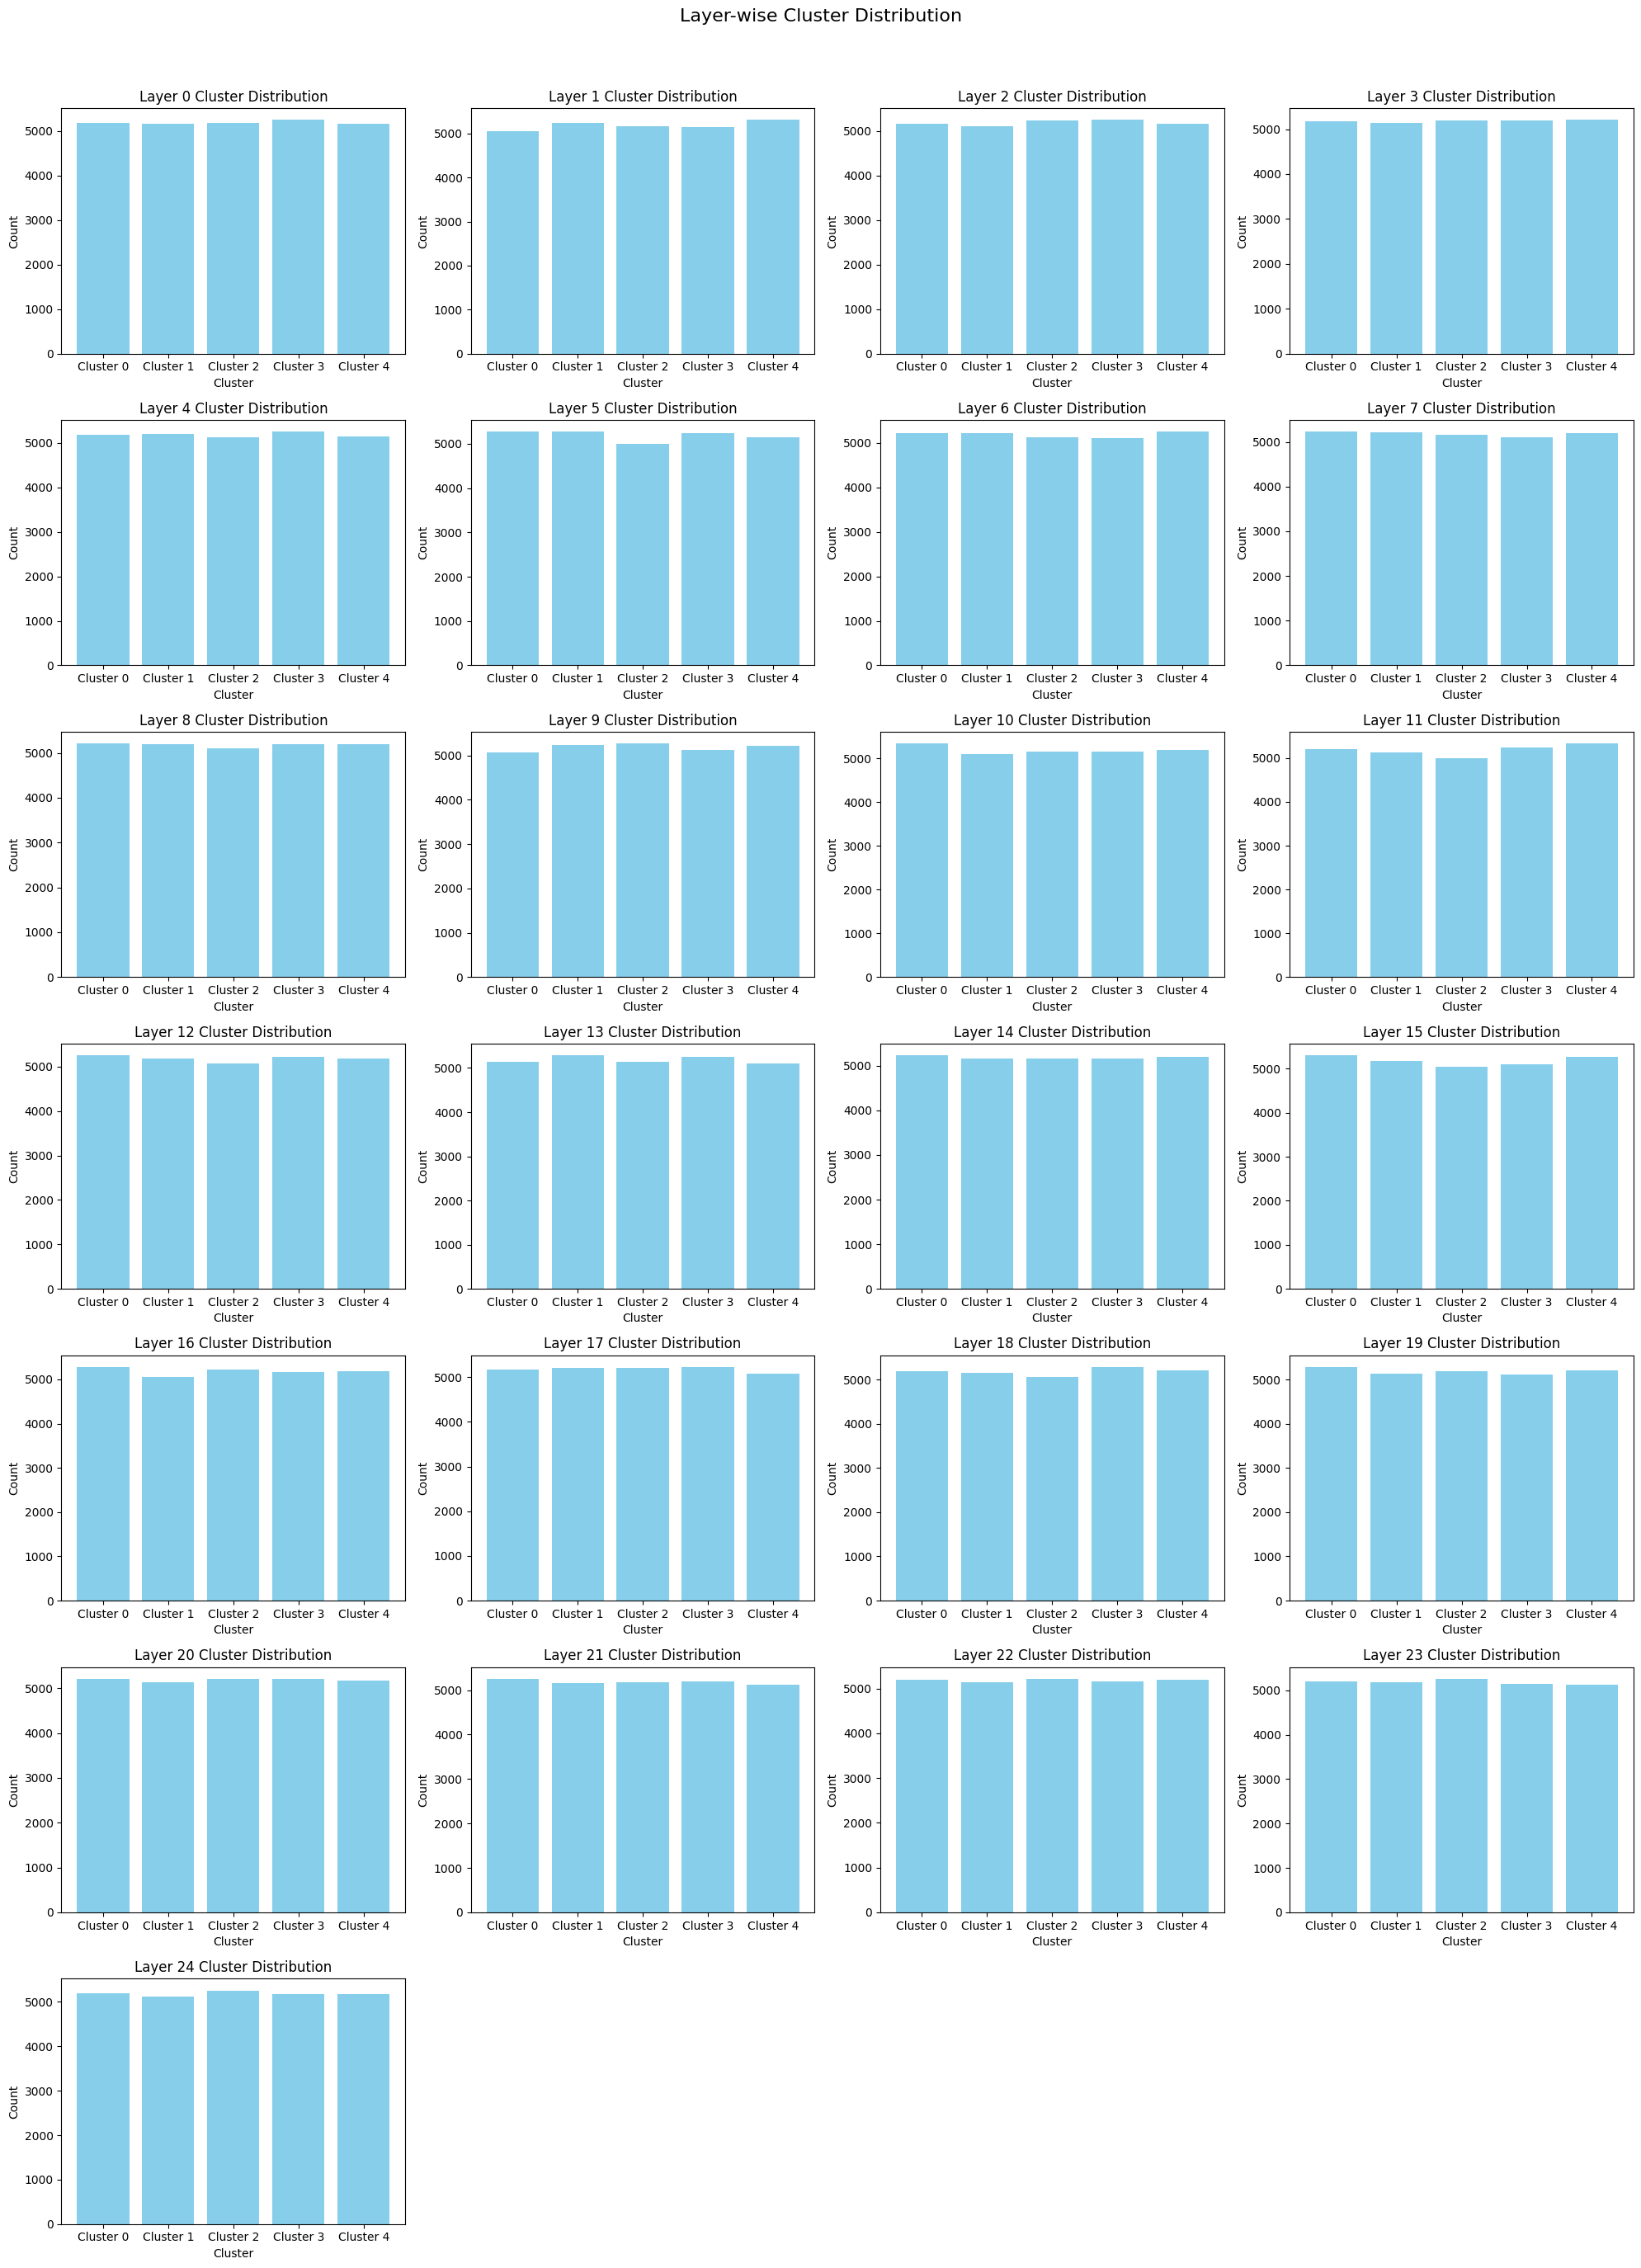

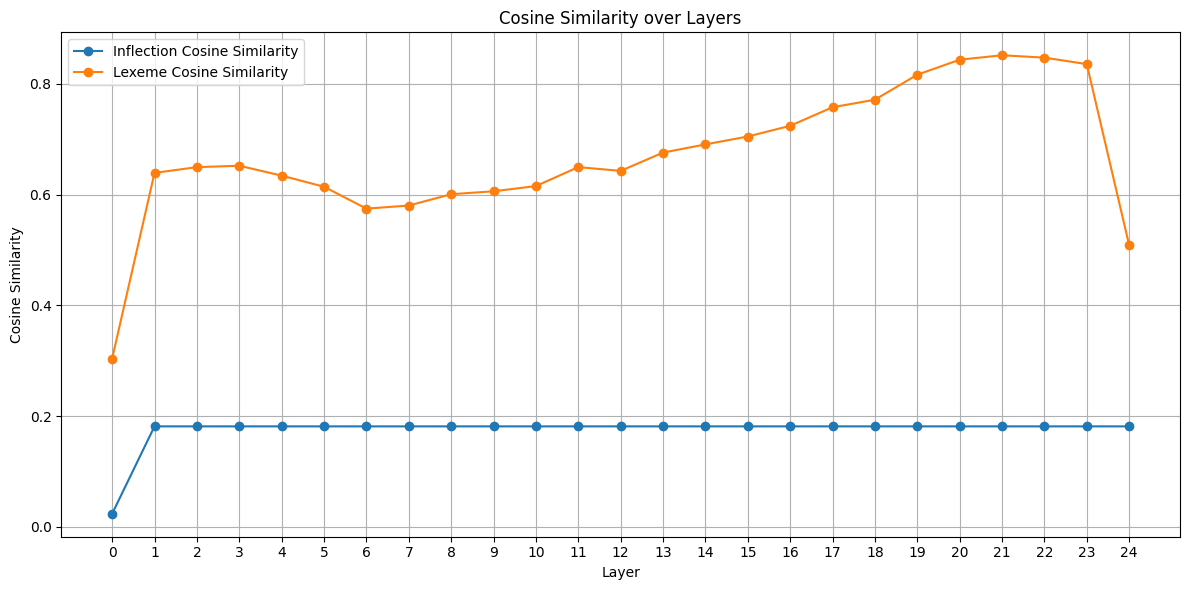

Layer 0: Cosine Inflection: 0.023425079882144928, Cosine Lexeme: 0.303530216217041
Layer 1: Cosine Inflection: 0.18134523928165436, Cosine Lexeme: 0.6392073035240173
Layer 2: Cosine Inflection: 0.18135538697242737, Cosine Lexeme: 0.6496395468711853
Layer 3: Cosine Inflection: 0.18134430050849915, Cosine Lexeme: 0.6521849632263184
Layer 4: Cosine Inflection: 0.18134452402591705, Cosine Lexeme: 0.634296178817749
Layer 5: Cosine Inflection: 0.18134434521198273, Cosine Lexeme: 0.6142340898513794
Layer 6: Cosine Inflection: 0.18132825195789337, Cosine Lexeme: 0.574687659740448
Layer 7: Cosine Inflection: 0.18133513629436493, Cosine Lexeme: 0.5802810788154602
Layer 8: Cosine Inflection: 0.18133915960788727, Cosine Lexeme: 0.6007117629051208
Layer 9: Cosine Inflection: 0.1813373863697052, Cosine Lexeme: 0.6060119271278381
Layer 10: Cosine Inflection: 0.18134458363056183, Cosine Lexeme: 0.6154403686523438
Layer 11: Cosine Inflection: 0.1813330054283142, Cosine Lexeme: 0.6496788859367371
Layer 

AttributeError: 'Index' object has no attribute '_format_native_types'

In [ ]:
analysis_npz_path = f"../output/{model_name}_{dataset}_analysis/analysis_results.npz"

data = np.load(analysis_npz_path, allow_pickle=True)
results = data["results"].item()

num_layers = len(results)
cols = 4
rows = ceil(num_layers / cols)

fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
axes = axes.flatten()

inflection_similarities = []
lexeme_similarities = []

for i, layer in enumerate(sorted(results.keys())):
    metrics = results[layer]
    cosine_inflection = metrics.get("cosine_inflection")
    cosine_lexeme = metrics.get("cosine_lexeme")
    cluster_labels = metrics.get("cluster_labels")
    
    inflection_similarities.append(cosine_inflection)
    lexeme_similarities.append(cosine_lexeme)
    
    ax = axes[i]
    
    if cluster_labels is not None:
        unique, counts = np.unique(cluster_labels, return_counts=True)
        ax.bar(unique, counts, tick_label=[f"Cluster {x}" for x in unique], color='skyblue')
        ax.set_xlabel("Cluster")
        ax.set_ylabel("Count")
        ax.set_title(f"Layer {layer} Cluster Distribution")
    else:
        ax.text(0.5, 0.5, "No cluster data", ha='center', va='center')
    
    ax.axis('on')

for i in range(num_layers, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.suptitle("Layer-wise Cluster Distribution", fontsize=16)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(sorted(results.keys()), inflection_similarities, marker='o', label='Inflection Cosine Similarity')
plt.plot(sorted(results.keys()), lexeme_similarities, marker='o', label='Lexeme Cosine Similarity')
plt.xlabel("Layer")
plt.ylabel("Cosine Similarity")
plt.title("Cosine Similarity over Layers")
plt.xticks(sorted(results.keys()))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

for layer in sorted(results.keys()):
    metrics = results[layer]
    cosine_inflection = metrics.get("cosine_inflection")
    cosine_lexeme = metrics.get("cosine_lexeme")
    print(f"Layer {layer}: Cosine Inflection: {cosine_inflection}, Cosine Lexeme: {cosine_lexeme}")
    
# Save the analysis results
analysis_results_file = os.path.join("output", "analysis", f"{model_name}_{dataset}_analysis_results.csv")
os.makedirs(os.path.dirname(analysis_results_file), exist_ok=True)

# Create DataFrame with results
results_data = {
    "Layer": list(range(num_layers)),
    "Cosine_Inflection": inflection_similarities,
    "Cosine_Lexeme": lexeme_similarities
}

# Convert to DataFrame and save
df_results = pd.DataFrame.from_dict(results_data)
df_results.to_csv(analysis_results_file, index=False)
print("Saved analysis results to", analysis_results_file)
